In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Loading

In [ ]:

DATA_FILE="newspapers_filtered_2024-04-30_18-17-52.jsonl"

from json import loads

data = [
    loads(line)
    for line in open(DATA_FILE, "r", encoding="utf-8").readlines()
]

print(f"Loaded {len(data)} records")

df = pd.DataFrame(data)

df["date"] = pd.to_datetime(df["date"])


In [ ]:
EMBEDDINGS_FILE = f"{DATA_FILE}_embeddings.npy"

embeddings = np.load(EMBEDDINGS_FILE)

df["embedding"] = [e for e in embeddings]

print(f"Loaded {len(embeddings)} embeddings")

In [ ]:
df.iloc[0]

# HDBSCAN

In [ ]:
import hdbscan

MIN_CLUSTER_SIZE = 10

## Dimension reduction using UMAP

In [ ]:
from umap import UMAP

# Specify the desired number of dimensions (K)
K = MIN_CLUSTER_SIZE

# Create a UMAP object with the specified number of dimensions
umap_reducer = UMAP(n_components=K, random_state=42)

# Fit and transform the embeddings to reduce dimensionality
umap_embeddings = umap_reducer.fit_transform(df['embedding'].tolist())

# Set the reduced embeddings as a list to each row in the DataFrame
df[f'umap_embedding{K}'] = umap_embeddings.tolist()

## Adding the date as a clustering feature

In [ ]:
df.sort_values("date", inplace=True)

In [ ]:
# Convert date to a numerical feature
df['date_feature'] = df['date'].astype('int64') / 10**18  # Adjust the scaling factor as needed

### Set features column

In [ ]:
# Combine the UMAP embedding and date feature
df['combined_features'] = df.apply(lambda row: row[f'umap_embedding{K}'] + [row['date_feature']], axis=1)

### Perform HDBSCAN clustering

In [ ]:
model = hdbscan.HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE, metric='euclidean', cluster_selection_method='eom')
labels = model.fit_predict(df['combined_features'].tolist())
df['cluster'] = labels

# Analyse clusters

In [22]:
# show titles from the biggest cluster (except noise cluster)


biggest_cluster = df[df['cluster']!=-1].value_counts('cluster').idxmax()

df[df['cluster']==biggest_cluster].sort_values('date')[['date', 'title']]

,date,title
4547,2022-02-11,Billie Holiday et les grandes voix du jazz
66565,2022-02-12,Monbazillac : du théâtre pour prévenir le sexi...
69953,2022-02-13,La danseuse soufie Rana Gorgani a fait tourner...
57778,2022-02-14,Saint-Symphorien : Rag Mama Rag en concert au ...
39864,2022-02-15,Bordeaux : la première création d’un duo du Co...
...,...,...
68261,2024-02-06,« Je savoure comme je n’ai jamais savouré » : ...
65550,2024-02-07,"Vidéos. Chanson : Hildebrandt, Emilie Marsh et..."
39587,2024-02-11,Le Taillan-Médoc : Pascal Viau et la chorale E...
10292,2024-02-11,Opéra de Bordeaux : « situation sociale alarma...


In [24]:
for cluster in df['cluster'].unique()[100:500]:
    min_date = df[df['cluster'] == cluster]['date'].min()
    max_date = df[df['cluster'] == cluster]['date'].max()
    duration = max_date - min_date

    print(f"Cluster {cluster} ({len(df[df['cluster'] == cluster])} articles, from {min_date} to {max_date}, duration: {duration})")
    for title in df[df['cluster'] == cluster].sort_values("date")["title"].head():
        print(f"  {title}")
    print()

Cluster 275 (118 articles, from 2022-02-17 00:00:00 to 2024-02-10 00:00:00, duration: 723 days 00:00:00)
  Jarnac: la piscine toute neuve pourra rouvrir en juin
  Une nageuse teste l’intégralité des piscines de Paris pour les classer "en toute subjectivité"
  Piscines de Bordeaux : les inscriptions aux activités aquatiques ouvrent le 14 mars
  Piscines: 25% des propriétaires sont des ouvriers, agriculteurs ou employés
  Des activités aquatiques  à découvrir près de Gajan

Cluster 599 (99 articles, from 2022-02-17 00:00:00 to 2024-02-12 00:00:00, duration: 725 days 00:00:00)
  Conseil municipal de Saintes : des rangs clairsemés, le groupe Machon en rang serré
  Pont-et-Massène. Six élus démissionnent, des élections complémentaires prévues
  Bolquère - Municipales partielles : un désistement enregistré avant le 2e tour
  Après la démission de deux élues de la majorité municipale, Rodez Citoyen s'interroge et dénonce
  La Roche-sur-Foron. Démission d’élus de l’opposition : une décision “i

### Number of clusters

Total number of clusters: 827


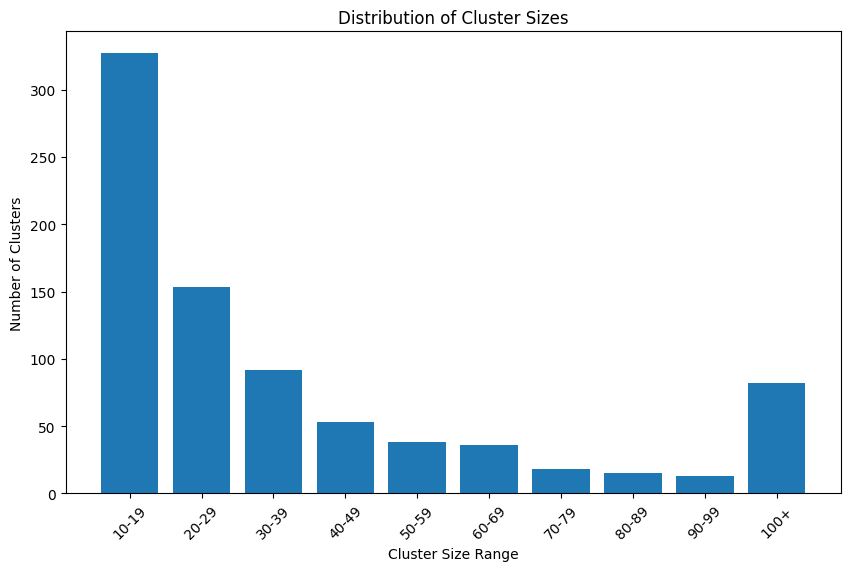

In [36]:

print(f"Total number of clusters: {df['cluster'].nunique()}")

# Get the cluster sizes
cluster_sizes = df['cluster'].value_counts()

# Define the bin edges
bin_edges = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]

# Create labels for the bins
bin_labels = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100+']

# Cut the cluster sizes into bins
binned_sizes = pd.cut(cluster_sizes, bins=bin_edges, labels=bin_labels, right=False)

# Count the number of clusters in each bin
bin_counts = binned_sizes.value_counts()

# Sort the bin counts in the desired order
bin_counts = bin_counts.reindex(bin_labels)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(bin_counts.index, bin_counts.values)
plt.xlabel('Cluster Size Range')
plt.ylabel('Number of Clusters')
plt.title('Distribution of Cluster Sizes')
plt.xticks(rotation=45)
plt.show()
